In [161]:
import json
import numpy as np
import os
import pandas as pd
import requests
import geopandas as gpd
import matplotlib.pyplot as plt
import pycocotools.mask as mask_util
from tqdm import tqdm
from scipy.spatial.distance import cdist
from scipy.ndimage import binary_dilation

In [3]:
base_url = "https://sidewalk-amsterdam.cs.washington.edu/v2/access/attributesWithLabels?lat1={}&lng1={}&lat2={}&lng2={}" 
whole = (52.303, 4.8, 52.425, 5.05)
centrum_west = (52.364925, 4.87444, 52.388692, 4.90641)
test = (52.0, 4.0, 53.0, 5.0)

coords = test

url = base_url.format(*coords)

local_dump = url.replace('/', '|')

try:
    project_sidewalk_labels = json.load(open(local_dump, 'r'))
except Exception as e:
    print("Couldn't load local dump")
    project_sidewalk_labels = requests.get(url.format(*coords)).json()
    json.dump(project_sidewalk_labels, open(local_dump, 'w'))

Couldn't load local dump


In [4]:
ps_labels_df = gpd.GeoDataFrame.from_features(project_sidewalk_labels['features'])
# Print length before filtering
print('Length before filtering:', len(ps_labels_df))

Length before filtering: 12446


In [5]:
# Send a get call to this API: https://sidewalk-amsterdam-test.cs.washington.edu/adminapi/labels/cvMetadata
other_labels = requests.get('https://sidewalk-amsterdam.cs.washington.edu/adminapi/labels/cvMetadata').json()
other_labels_df = pd.DataFrame(other_labels)
print(len(other_labels_df))

28116


In [6]:
# Filter labels dataframe to only contain obstacles
ps_labels_df = ps_labels_df[ps_labels_df['label_type'] == 'Obstacle']

# Intersect other_labels_df with ps_labels_df
other_labels_df = other_labels_df[other_labels_df['gsv_panorama_id'].isin(ps_labels_df['gsv_panorama_id'])]
print('Number of labels in other_labels_df after filtering for obstacles: ', len(other_labels_df))
print(other_labels_df[['gsv_panorama_id','sv_image_x', 'sv_image_y']].head(20))

Number of labels in other_labels_df after filtering for obstacles:  4523
            gsv_panorama_id  sv_image_x  sv_image_y
13   QG9izCWflOTRFfj1p8ayOg        2360        -581
14   QG9izCWflOTRFfj1p8ayOg        6293        -591
15   XKsEqcQnS38rGe1A93j3Zw        7277        -967
16   ESLyc1nlqIJAYjY3UMEyfA       10429        -906
17   ESLyc1nlqIJAYjY3UMEyfA        9960        -733
18   ESLyc1nlqIJAYjY3UMEyfA         201        -711
19   o7mvSW5tdQZ-Dk6E8r7GQA       12514        -553
20   QsCR87yYsMYz6Sl0N_LEfQ         300        -977
21   rS0oWMLWPld5C72IxGe4Ag       12835        -212
22   rS0oWMLWPld5C72IxGe4Ag        3556        -693
23   emPYfwR18hDQsjA616KQEg        5433        -954
37   30_uqDtY60Ms8gWU_F3GfA         648       -1076
81   8pZ19pRbIkT6g8ZXKlXa1A        2315        -862
82   8pZ19pRbIkT6g8ZXKlXa1A        8689       -1254
96   gT7cl9lDgCEjCU9WRFonZQ       11023        -684
109  EJLrfstQRrB54xmsf6kMjw        3861       -1415
123  UpFNL6vpZUx9rcFwfSJC5g        4846    

In [106]:
def visualize_label(dataframe, pano_id):

    image_path = f'../res/dataset_PS/centrum_west_small/reoriented/{pano_id}'
    mask_path = f'../res/dataset_PS/centrum_west_small/backprojected/{pano_id}/{pano_id}.png'
    image = plt.imread(image_path)
    mask = plt.imread(mask_path)

    # Find all the labels in the panorama
    labels = dataframe[dataframe['gsv_panorama_id'] == pano_id]

    labels_coords = []

    fig = plt.figure()
    plt.imshow(image, cmap='gray')
    plt.imshow(mask, cmap='jet', alpha=0.4)

    # For each label, find its coordinates in the panorama
    for index, row in labels.iterrows():
        #print('Labels coming from panorama:', row['gsv_panorama_id'])
        label_name = row['label_id']
        image_width = row['image_width']
        image_height = row['image_height']
        sv_image_x = row['sv_image_x']
        # Momentarily change the definition of sv_image_y. For now,
        # sv_image_y is the offset w.r.t. the middle of the image
        # which means that the real y coordinate is y = (image_width / 2) - sv_image_y
        sv_image_y = row['sv_image_y']
        real_y = (image_height / 2) - sv_image_y

        #print(f'Original image width: {image_width}, height: {image_height}')
        #print(f'Original label {label_name} coordinates: {sv_image_x}, {sv_image_y}')
        #print(f'Original label {label_name} with real y-coordinates' \
        #    f'({image_height}/2){sv_image_y}: {sv_image_x}, {real_y}')

        # image_width : sv_image_x = my_pano_width : sv_pano_x
        # sv_pano_x = (sv_image_x * my_pano_width) / image_width
        sv_pano_x = int(sv_image_x*image.shape[1]/image_width)
        sv_pano_y = int(real_y*image.shape[0]/image_height)

        #print(f'Scaled label {label_name} coordinates: {sv_pano_x}, {sv_pano_y} \n')

        # Visualize the point (sv_pano_x, sv_pano_y) on the image
        #print(f'Label {label_name} coordinates: {sv_pano_x}, {sv_pano_y} \n')
        plt.scatter(sv_pano_x, sv_pano_y, color='red', s=10)
        

        labels_coords.append((sv_pano_y, sv_pano_x))

    #plt.show()
    # Make a folder 'visualized' if not present
    if not os.path.exists(f'../res/dataset_PS/centrum_west_small/visualized'):
        os.makedirs(f'../res/dataset_PS/centrum_west_small/visualized')
    # Save the image
    #fig.savefig(f'../res/dataset_PS/centrum_west_small/visualized/{pano_id}.png', dpi=300, bbox_inches='tight')

    return labels_coords

In [107]:
'''def split_masks(pred_mask):
    # Determine the center of the image
    center = pred_mask.shape[1] // 2

    # Create two new images with the same dimensions as the original image
    mask1 = np.zeros_like(pred_mask)
    mask2 = np.zeros_like(pred_mask)

    # Copy the first half of the original image to the first new image
    # and blacken the second half
    mask1[:, :center] = pred_mask[:, :center]

    # Copy the second half of the original image to the second new image
    # and blacken the first half
    mask2[:, center:] = pred_mask[:, center:]

    return mask1, mask2'''

'def split_masks(pred_mask):\n    # Determine the center of the image\n    center = pred_mask.shape[1] // 2\n\n    # Create two new images with the same dimensions as the original image\n    mask1 = np.zeros_like(pred_mask)\n    mask2 = np.zeros_like(pred_mask)\n\n    # Copy the first half of the original image to the first new image\n    # and blacken the second half\n    mask1[:, :center] = pred_mask[:, :center]\n\n    # Copy the second half of the original image to the second new image\n    # and blacken the first half\n    mask2[:, center:] = pred_mask[:, center:]\n\n    return mask1, mask2'

In [159]:
def point_to_mask_distance(gt_points, pred_masks):
    distances = []
    closest_points = []
    mask_indices = []

    for gt_point in gt_points:
        min_distance = float('inf')
        closest_y, closest_x = -1, -1
        mask_index = -1

        for idx, pred_mask in enumerate(pred_masks):
            if pred_mask.ndim == 2:  # Check if the mask is 2D
                mask_channel = pred_mask
            elif pred_mask.ndim == 3:  # Check if the mask is 3D
                mask_channel = pred_mask[:, :, 0]  # Assuming the first channel contains the binary mask
            else:
                raise ValueError("Invalid mask dimensions")

            mask_coords = np.where(mask_channel > 0)  # Get the indices of non-zero elements (i.e., the mask)
            mask_coords = np.vstack(mask_coords).T  # Stack the mask indices into a 2D array

            point_coords = np.array(gt_point).reshape(1, -1)
            dist = cdist(point_coords, mask_coords)

            local_min_distance_idx = np.argmin(dist)
            local_min_distance = dist[0, local_min_distance_idx]
            local_closest_y, local_closest_x = mask_coords[local_min_distance_idx]

            if local_min_distance < min_distance:
                min_distance = local_min_distance
                closest_y, closest_x = local_closest_y, local_closest_x
                mask_index = idx

        distances.append(min_distance)
        closest_points.append((closest_y, closest_x))
        mask_indices.append(mask_index)

    return distances, closest_points, mask_indices

In [215]:
def mask_to_point_distance(gt_points, pred_masks):
    distances = []
    closest_points = []
    gt_indices = []

    for idx, pred_mask in enumerate(pred_masks):
        min_distance = float('inf')
        closest_y, closest_x = -1, -1
        gt_point_index = -1

        if pred_mask.ndim == 2:  # Check if the mask is 2D
            mask_channel = pred_mask
        elif pred_mask.ndim == 3:  # Check if the mask is 3D
            mask_channel = pred_mask[:, :, 0]  # Assuming the first channel contains the binary mask
        else:
            raise ValueError("Invalid mask dimensions")

        mask_coords = np.where(mask_channel > 0)  # Get the indices of non-zero elements (i.e., the mask)
        mask_coords = np.vstack(mask_coords).T  # Stack the mask indices into a 2D array

        for gt_idx, gt_point in enumerate(gt_points):
            point_coords = np.array(gt_point).reshape(1, -1)
            dist = cdist(point_coords, mask_coords)

            local_min_distance_idx = np.argmin(dist)
            local_min_distance = dist[0, local_min_distance_idx]
            local_closest_y, local_closest_x = mask_coords[local_min_distance_idx]

            if local_min_distance < min_distance:
                min_distance = local_min_distance
                closest_y, closest_x = local_closest_y, local_closest_x
                gt_point_index = gt_idx

        distances.append(min_distance)
        closest_points.append((closest_y, closest_x))
        gt_indices.append(gt_point_index)

    return distances, closest_points, gt_indices

In [273]:
def point_to_mask_best_iou(gt_points, pred_masks, radius=5):
    best_ious = []
    best_gt_point_indices = []

    # Generate a grid of coordinates for the entire image
    y_coords, x_coords = np.indices(pred_masks[0].shape)
    coords = np.column_stack((y_coords.ravel(), x_coords.ravel()))

    for idx, pred_mask in enumerate(pred_masks):
        max_iou = 0
        best_gt_point_index = -1

        for point_idx, gt_point in enumerate(gt_points):
            # Compute the distance from the ground truth point to all other points
            distances = cdist([gt_point], coords).reshape(pred_mask.shape)

            # Create a dilated mask by thresholding the distance matrix at the specified radius
            gt_mask_dilated = (distances <= radius).astype(int)

            # Calculate IoU
            intersection = np.sum(np.logical_and(gt_mask_dilated, pred_mask))
            union = np.sum(np.logical_or(gt_mask_dilated, pred_mask))
            iou = intersection / union

            # Update the best IoU and ground truth point index
            if iou > max_iou:
                max_iou = iou
                best_gt_point_index = point_idx

        best_ious.append(max_iou)
        best_gt_point_indices.append(best_gt_point_index)

    #print(f'Best IoUs: {best_ious}')
    #print(f'Best ground truth point indices: {best_gt_point_indices}')

    return best_ious, best_gt_point_indices

In [302]:
def precision_recall_f1(distances, closest_points, gt_indices, threshold):
    true_positives = 0
    false_positives = 0
    false_negatives = 0

    matched_gt_indices = set()

    # Count true positives and false positives
    for distance, gt_idx in zip(distances, gt_indices):
        if distance <= threshold:
            true_positives += 1
            matched_gt_indices.add(gt_idx)
        else:
            false_positives += 1

    # Count false negatives
    false_negatives = len(gt_indices) - len(matched_gt_indices)

    '''True Negative (TN) — Background region correctly not detected by the model. 
    This metric is not used in object detection because such regions are not explicitly
    annotated when preparing the annotations.'''

    print(f"True positives: {true_positives}, False positives: {false_positives}, False negatives: {false_negatives}")

    # Deal with division by zero exception (true_positives + false_positives == 0 or true_positives + false_negatives == 0)
    if true_positives + false_positives == 0:
        precision = 0
        recall = 0
        f1_score = 0
    elif true_positives + false_negatives == 0:
        precision = 0
        recall = 0
        f1_score = 0
    else:
        precision = true_positives / (true_positives + false_positives)
        recall = true_positives / (true_positives + false_negatives)
    if precision + recall == 0:
        f1_score = 0
    else:
        f1_score = 2 * (precision * recall) / (precision + recall)

    
    #print(f"Precision: {precision:.3f}, Recall: {recall:.3f}, F1-score: {f1_score:.3f}")
    return precision, recall, f1_score

In [210]:
def visualize_debug(gt_points, pred_masks, distances, closest_points, mask_indices):
    num_masks = len(pred_masks)
    fig, axes = plt.subplots(num_masks, 1, figsize=(5, 3 * num_masks))

    for idx, (pred_mask, ax) in enumerate(zip(pred_masks, axes)):
        seen_labels = set()  # Keep track of labels already added

        ax.imshow(pred_mask)  # Display the predicted mask

        for gt_point, distance, closest_point, mask_index in zip(gt_points, distances, closest_points, mask_indices):
            if mask_index == idx:
                y, x = gt_point
                closest_y, closest_x = closest_point

                # Add labels only if they haven't been added before
                gt_label = 'Ground Truth' if 'Ground Truth' not in seen_labels else None
                dist_label = 'Distance' if 'Distance' not in seen_labels else None
                closest_label = 'Closest Point' if 'Closest Point' not in seen_labels else None

                ax.scatter(x, y, c='red', marker='x', s=50, label=gt_label)  # Mark the ground truth point
                ax.plot([x, closest_x], [y, closest_y], 'r--', label=dist_label)  # Draw the distance line
                ax.scatter(closest_x, closest_y, c='blue', marker='o', s=20, label=closest_label)  # Mark the closest point

                # Update seen_labels
                seen_labels.update([label for label in (gt_label, dist_label, closest_label) if label is not None])

        ax.set_title(f"Closest point-to-mask distance for mask {idx + 1}")
        ax.legend()

    plt.tight_layout()
    plt.show()

In [279]:
def visualize_debug_mask(gt_points, pred_masks, distances, closest_points, gt_indices):
    num_masks = len(pred_masks)
    fig, axes = plt.subplots(num_masks, 1, figsize=(5, 3 * num_masks))

    for idx, (pred_mask, ax) in enumerate(zip(pred_masks, axes)):
        ax.imshow(pred_mask)  # Display the predicted mask

        # Retrieve the correct ground truth point, distance, and closest point
        gt_point = gt_points[gt_indices[idx]]
        distance = distances[idx]
        closest_point = closest_points[idx]
        
        y, x = gt_point
        closest_y, closest_x = closest_point

        ax.scatter(x, y, c='red', marker='x', s=50, label='Ground Truth')  # Mark the ground truth point
        ax.plot([x, closest_x], [y, closest_y], 'r--', label='Distance')  # Draw the distance line
        ax.scatter(closest_x, closest_y, c='blue', marker='o', s=20, label='Closest Point')  # Mark the closest point

        ax.set_title(f"Closest mask-to-point distance for mask {idx + 1}")
        ax.legend()

    plt.tight_layout()
    plt.show()

    fig.savefig(f'../res/dataset_PS/centrum_west_small/visualized/{pano_id}_mask.png', dpi=300, bbox_inches='tight')

In [280]:
def visualize_best_dilated(gt_points, pred_masks, best_gt_point_indices, radius=5):
    num_masks = len(pred_masks)
    fig, axes = plt.subplots(num_masks, 1, figsize=(5, 3 * num_masks))

    # Generate a grid of coordinates for the entire image
    y_coords, x_coords = np.indices(pred_masks[0].shape)
    coords = np.column_stack((y_coords.ravel(), x_coords.ravel()))

    for idx, (pred_mask, ax) in enumerate(zip(pred_masks, axes)):
        best_gt_point = gt_points[best_gt_point_indices[idx]]

        # Compute the distance from the best ground truth point to all other points
        distances = cdist([best_gt_point], coords).reshape(pred_mask.shape)

        # Create a dilated mask by thresholding the distance matrix at the specified radius
        gt_mask_dilated = (distances <= radius).astype(int)

        # Display the dilated ground truth mask
        ax.imshow(gt_mask_dilated, alpha=0.5, cmap='gray', label='Dilated Ground Truth')

        # Display the predicted mask
        ax.imshow(pred_mask, alpha=0.5, cmap='jet', label='Predicted Mask')

        # Mark the best ground truth point
        ax.scatter(best_gt_point[1], best_gt_point[0], c='red', marker='x', s=50, label='Ground Truth')

        ax.set_title(f"Best dilated ground truth point and mask {idx + 1}")
        ax.legend()

    plt.tight_layout()
    plt.show()

    fig.savefig(f'../res/dataset_PS/centrum_west_small/visualized/{pano_id}_mask_iou.png', dpi=300, bbox_inches='tight')

In [298]:
def average_precision(distances, closest_points, gt_indices, threshold):
    true_positives = 0
    false_positives = 0
    n_gt_points = len(gt_indices)

    matched_gt_indices = set()

    # Count true positives and false positives
    for distance, gt_idx in zip(distances, gt_indices):
        if distance <= threshold:
            true_positives += 1
            matched_gt_indices.add(gt_idx)
        else:
            false_positives += 1

    tp_cumsum = np.cumsum(true_positives)
    fp_cumsum = np.cumsum(false_positives)

    precisions = tp_cumsum / (tp_cumsum + fp_cumsum)
    recalls = tp_cumsum / n_gt_points

    precisions = np.concatenate(([0], precisions, [0]))
    recalls = np.concatenate(([0], recalls, [1]))

    for i in range(len(precisions) - 2, -1, -1):
        precisions[i] = max(precisions[i], precisions[i + 1])

    i = np.where(recalls[1:] != recalls[:-1])[0]
    ap = np.sum((recalls[i + 1] - recalls[i]) * precisions[i + 1])

    return ap

In [276]:
def average_precision_iou(best_ious, best_gt_point_indices, gt_points, threshold):
    num_gt_points = len(gt_points)
    num_pred_masks = len(best_ious)

    sorted_indices = sorted(range(num_pred_masks), key=lambda i: best_ious[i], reverse=True)
    sorted_best_gt_point_indices = [best_gt_point_indices[i] for i in sorted_indices]
    sorted_best_ious = [best_ious[i] for i in sorted_indices]

    tp = [1 if iou >= threshold else 0 for iou in sorted_best_ious]
    fp = [1 - t for t in tp]

    tp_cumsum = np.cumsum(tp)
    fp_cumsum = np.cumsum(fp)

    precisions = tp_cumsum / (tp_cumsum + fp_cumsum)
    recalls = tp_cumsum / num_gt_points

    precisions = np.concatenate(([0], precisions, [0]))
    recalls = np.concatenate(([0], recalls, [1]))

    for i in range(len(precisions) - 2, -1, -1):
        precisions[i] = max(precisions[i], precisions[i + 1])

    i = np.where(recalls[1:] != recalls[:-1])[0]
    ap = np.sum((recalls[i + 1] - recalls[i]) * precisions[i + 1])

    return ap

In [292]:
# Choose a random pano_id from other_labels_df
#pano_id = other_labels_df['gsv_panorama_id'].sample(1).values[0]
#pano_id = 'olwK2geLCfd8HG3KHlGlGA'
#print(f'Pano ID: {pano_id}')
#mask_path = f'../res/dataset_PS/centrum_west_small/backprojected/{pano_id}/{pano_id}.png'
#pred_masks = plt.imread(mask_path)
#print(f'The shape of the mask is: {pred_masks.shape}')
#mask1, mask2 = split_masks(pred_masks)

# Open .json file from res/dataset/centrum_west_small/backprojected/input_coco_format.json
with open('../res/dataset_PS/centrum_west_small/backprojected/input_coco_format.json') as f:
    data = json.load(f)

# The structure of data is a list of dictionaries, with instance['pano_id'] as the panorama ID
# and instance['segmentation'] as the corresponding masks. Make a dictionary of masks with
# the panorama ID as the key and a list of masks as value.
panos = {}
for instance in data[50:80]:
    pano_id = instance['pano_id'].replace(".jpg", "")
    mask = mask_util.decode(instance['segmentation'])
    if pano_id not in panos:
        panos[pano_id] = []
    panos[pano_id].append(mask)

  0%|          | 0/8 [00:00<?, ?it/s]

Pano: 0X1EzeV1Gae6VgvEonwc6w
Number of predicted masks: 4


 38%|███▊      | 3/8 [00:01<00:02,  1.80it/s]

True positives: 2, False positives: 2, False negatives: 2


==== Printing metrics for pano 0X1EzeV1Gae6VgvEonwc6w: ====
Average point-to-mask distance: 374.568
Average best IoU: 0.086
== Distance-based metrics, threshold: 100 ==
Precision: 0.500, Recall: 0.500, F1: 0.500
Average Precision: 0.250
== IoU-based metrics, threshold: 0.5 ==
Average Precision @50 (IoU): 0.000
Average Precision @75 (IoU): 0.000
Pano: MsKi1k5Oj76pj8cCFxko5w
Number of predicted masks: 4


100%|██████████| 8/8 [00:03<00:00,  2.06it/s]

True positives: 0, False positives: 4, False negatives: 4


==== Printing metrics for pano MsKi1k5Oj76pj8cCFxko5w: ====
Average point-to-mask distance: 266.122
Average best IoU: 0.013
== Distance-based metrics, threshold: 100 ==
Precision: 0.000, Recall: 0.000, F1: 0.000
Average Precision: 0.062
== IoU-based metrics, threshold: 0.5 ==
Average Precision @50 (IoU): 0.000
Average Precision @75 (IoU): 0.000


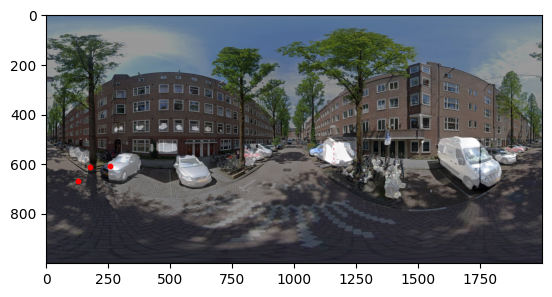

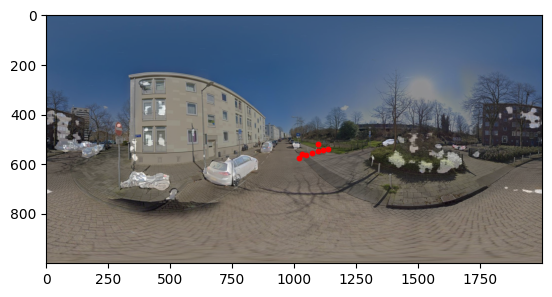

In [303]:
# Visualize the masks and the point labels in each panorama (and save the images)
# Beware that for visualization we retrieve the entire mask for each panorama, while
# in the metrics computation we will distinguish separate masks (front,back,left,right)
for pano in tqdm(panos):
    if pano in other_labels_df["gsv_panorama_id"].values:
        print(f'Pano: {pano}')
        gt_points = visualize_label(other_labels_df, pano)

        # Compute metrics
        pred_masks = panos[pano]
        print(f'Number of predicted masks: {len(pred_masks)}')
        # Metrics 1: (average) point-to-mask distance
        distances, closest_points, gt_indices = mask_to_point_distance(gt_points, pred_masks)
        avg_distance = np.mean(distances)
        '''Assumptions: there is one ground truth for each mask, 
        and the order of the masks is the same as the order of the ground truth indices.'''
        #--> correct visualize_debug_mask(gt_points, pred_masks, distances, closest_points, gt_indices)
        #distances, closest_points, mask_indices = point_to_mask_distance(gt_points, pred_masks)
        #visualize_debug(gt_points, pred_masks, distances, closest_points, mask_indices)
        #print('Printing ground truth points: ', gt_points)
        #print('Printing closest_points: ', closest_points)
        #print('Distances of labels to masks (left,right,front,back): ', distances)
        #print('Closest points of masks to labels (left,right,front,back): ', closest_points)
        #print('Indices of labels to masks (left,right,front,back): ', gt_indices)
        # Metrics 2: point-to-mask best IoU
        best_ious, best_gt_point_indices = point_to_mask_best_iou(gt_points, pred_masks, radius=100)
        avg_ious = np.mean(best_ious)
        #--> correct visualize_best_dilated(gt_points, pred_masks, best_gt_point_indices, radius=100)
        # Metrics 3: Precision, Recall, F1 (already uses closest_points based on point-to-mask distance)
        precision, recall, f1 = precision_recall_f1(distances, closest_points, gt_indices, threshold=10)
        # Metrics 4: Average precision based on point-to-mask distance
        ap = average_precision(distances, closest_points, gt_indices, threshold=100)
        # Metrics 5: Average precision @50 and @75 based on IoU
        # Print best ious with 3 decimals, considering that it's a list of numbers
        ap_50 = average_precision_iou(best_ious, best_gt_point_indices, gt_points, threshold=0.5)
        ap_75 = average_precision_iou(best_ious, best_gt_point_indices, gt_points, threshold=0.75)
        # We can't do mAP because at the moment there is only one class (obstacles)

        # Print all the metrics in a pretty way
        print(f"\n")
        print(f"==== Printing metrics for pano {pano}: ====")
        print(f"Average point-to-mask distance: {avg_distance:.3f}")
        print(f"Average best IoU: {avg_ious:.3f}")
        print(f"== Distance-based metrics, threshold: 100 ==")
        print(f"Precision: {precision:.3f}, Recall: {recall:.3f}, F1: {f1:.3f}")
        print(f"Average Precision: {ap:.3f}")
        print(f"== IoU-based metrics, threshold: 0.5 ==")
        print(f"Average Precision @50 (IoU): {ap_50:.3f}")
        print(f"Average Precision @75 (IoU): {ap_75:.3f}")

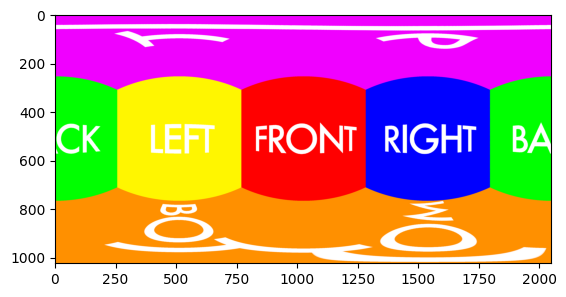

In [263]:
# Visualize the image with path '../res/equirectangular.png' with matplotlib
img = plt.imread('../res/equirectangular.png')
plt.imshow(img)